In [1]:
import pandas as pd
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
from scipy.sparse import vstack, hstack, csr_matrix


In [2]:
def letter_counter(string, type=None):
    if (type == 'c'):
        return {letter: str(string).count(letter) for letter in 'bcdfghjklmnpqrstvwxyz'}
    elif (type == 'v'):
        return {letter: str(string).count(letter) for letter in 'aeiou'}  
    return {letter: str(string).count(letter) for letter in 'abcdefghijklmnopqrstuvwxyz'}

def type_counter(string, type):    
    return sum(letter_counter(string, type).values())

def type_ratio(string, type):
    if (len(string) == 0):
        return 0
    return type_counter(string, type)/len(string)

def repetitions_character(repetitions, caractere):
        x = repetitions.get(caractere)
        return x if x != None else 0

def ttr(string):
    if (len(string) == 0):
        return 0
    ttr = len(set(string)) / len(string)
    return ttr
    
def repetitions(string):
    try:
        resultados = []
        size = len(string)
        valor = 1

        for l in range(0, size):
            if l <= size-2 and string[l] == string[l+1]:
                valor += 1
            else:
                resultados.append(tuple((string[l], valor)))
                valor = 1
        return dict(sorted(resultados))
    except:
        return {}

def repetitions_type(string, type):
    if type == 'c':
        letters = 'bcdfghjklmnpqrstvwxyz'
    else:
        letters = 'aeiou'
    
    resultados = []
    size = len(string)
    valor = 0

    for l in string:
        if l in letters:
            valor += 1
        else:
            resultados.append(valor)
            valor = 0
    resultados.append(valor)
    
    return max(resultados)

def bigram_counter(lista):
  dic = {}
  for i in lista:
    if i in dic:
      dic[i] +=1
    else:
      dic[i] =1
  return dic

def bigrams(string):
    bigrams = []
    for i in range(len(string)-1):
        bigrams.append(string[i]+string[i+1])

    return bigram_counter(bigrams)

def bigram_max_occurance(string):
    try:
        return (sorted(bigrams(string).values(), reverse=True))[0]
    except:
        return 0

In [3]:
with open ("..\\data\\interim\\naturals.csv", "r", encoding="utf-8") as file0:
    X0 = pd.DataFrame(pd.read_csv(file0, keep_default_na=False))

with open ("..\\data\\interim\\mashings.csv", "r", encoding="utf-8") as file1:
    X1 = pd.DataFrame(pd.read_csv(file1, keep_default_na=False))

with open ("..\\data\\processed\\rfdata.csv", "r", encoding="utf-8") as file1:
    df2 = pd.DataFrame(pd.read_csv(file1, keep_default_na=False))

In [4]:
#O dataframe naturals é embaralhado e reduzido para o tamanho do de mashings
X0 = shuffle(X0, random_state=777).reset_index(drop=True)
X0 = X0[:len(X1)]
X0

,0
0,resembles
1,attacks
2,under
3,having
4,point
...,...
11648,It
11649,bloom
11650,weights
11651,in


In [5]:
#Add da coluna binária 'mash'
X0["mash"] = 0
X1["mash"] = 1
print(X0)

               0  mash
0      resembles     0
1        attacks     0
2          under     0
3         having     0
4          point     0
...          ...   ...
11648         It     0
11649      bloom     0
11650    weights     0
11651         in     0
11652        use     0

[11653 rows x 2 columns]


In [6]:
df = pd.concat([X0, X1], axis=0).rename(columns={'0':'words'}, inplace=False).reset_index(drop=True)
df

,words,mash
0,resembles,0
1,attacks,0
2,under,0
3,having,0
4,point,0
...,...,...
23301,wpetqiitqyprypiy,1
23302,ywyeoiwtopypotpi,1
23303,tpoiouteiwppweiq,1
23304,pyiitiwiuyootpyq,1


In [7]:
# Extract N-grams
# vectorizer = TfidfVectorizer(ngram_range=(2, 3), analyzer='char')
vectorizer = CountVectorizer(ngram_range=(2, 4), analyzer='char', stop_words=None)
ngram_features = vectorizer.fit_transform(df2['words'])
# ngram_features = vectorizer.fit_transform(df['words']).toarray()
ngram_features.shape

(23306, 153986)

In [8]:
# Extract N-grams
# vectorizer = TfidfVectorizer(ngram_range=(2, 3), analyzer='char')
vectorizer = CountVectorizer(ngram_range=(2, 4), analyzer='char', stop_words=None)
ngram_features = vectorizer.fit_transform(df['words'])
# ngram_features = vectorizer.fit_transform(df['words']).toarray()
ngram_features.shape

(23306, 153986)

In [9]:
#Análise de tamanho e razão de vogais e consoantes e de TTR

aux = df.copy()
aux["vowel rt"] = aux["words"].apply(lambda x : type_ratio(str(x), 'v'))
aux["consonant rt"] = aux["vowel rt"].apply(lambda x : 1-x)
aux["ttr"] = aux["words"].apply(ttr)
aux

,words,mash,vowel rt,consonant rt,ttr
0,resembles,0,0.333333,0.666667,0.666667
1,attacks,0,0.285714,0.714286,0.714286
2,under,0,0.400000,0.600000,1.000000
3,having,0,0.333333,0.666667,1.000000
4,point,0,0.400000,0.600000,1.000000
...,...,...,...,...,...
23301,wpetqiitqyprypiy,1,0.250000,0.750000,0.500000
23302,ywyeoiwtopypotpi,1,0.375000,0.625000,0.437500
23303,tpoiouteiwppweiq,1,0.500000,0.500000,0.500000
23304,pyiitiwiuyootpyq,1,0.437500,0.562500,0.500000


In [10]:
vowel_feature = csr_matrix(np.array(aux["vowel rt"]).reshape(-1,1))
consonant_feature = csr_matrix(np.array(aux["consonant rt"]).reshape(-1,1))
ttr_feature = csr_matrix(np.array(aux["ttr"]).reshape(-1,1))

In [ ]:
print(f"vowel_feature.shape: {vowel_feature.shape}\nconsonant_feature.shape: {consonant_feature.shape}\nttr_feature.shape: {ttr_feature.shape}\n")

vowel_feature.shape: (30672, 1)
consonant_feature.shape: (30672, 1)
ttr_feature.shape: (30672, 1)



In [11]:
lexical_features = hstack((vowel_feature, consonant_feature, ttr_feature))
lexical_features.shape

(23306, 3)

In [360]:
# Normalize the features (optional)
scaler = StandardScaler(with_mean=False)
lexical_features = scaler.fit_transform(np.abs(lexical_features))
features


<23306x153989 sparse matrix of type '<class 'numpy.float64'>'
	with 636097 stored elements in Compressed Sparse Row format>

In [12]:
features = hstack((lexical_features, ngram_features))
features.shape

(23306, 153989)

In [99]:
from sklearn.feature_selection import SelectKBest, chi2

# Define the number of top features to select
k = 30000

ngram_targets = df["mash"].to_numpy()

# Fit the feature selector to the training data
selector = SelectKBest(chi2, k=k).fit(ngram_features, ngram_targets)

# # # Transform the training and testing data to only include the top k features
# feature_train_sel = selector.transform(ngram_features)
# labels_test_selected = selector.transform(ngram_targets)


best_ngram_features = selector.transform(ngram_features)
best_ngram_features.shape

(23306, 30000)

In [100]:
best_features = hstack((lexical_features, best_ngram_features))
best_features.shape

(23306, 30003)

In [194]:
feature_names = vectorizer.get_feature_names_out()
for feature in feature_names:
    print(feature)


array([' #', ' # ', ' # 4', ..., 'üü', 'üü¡', 'üü¡¿'], dtype=object)
 #
 # 
 # 4
 &
 & 
 & m
 (
 ()
 (){
 (.
 (.,
 ,
 ,v
 ,vl
 /
 / 
 / 1
 1
 1 
 1 u
 12
 13
 13,
 2
 21
 21p
 3
 3k
 3kp
 4
 45
 456
 8
 89
 89f
 a
 ad
 adk
 adp
 ap
 ap´
 as
 asd
 ax
 axu
 b
 bf
 bfm
 c
 ch
 chg
 c~
 c~ç
 d
 da
 dak
 dap
 das
 dj
 djj
 dk
 dkf
 dm
 dma
 dmk
 do
 dop
 ds
 dsa
 dsp
 e
 ea
 eaq
 ei
 eio
 ek
 ekq
 eo
 eop
 ep
 epo
 eq
 eqw
 f
 f 
 f s
 f[
 f[]
 fa
 fa9
 faj
 fas
 fd
 fds
 fj
 fjl
 fjs
 fk
 fkj
 fkl
 fko
 fkp
 fks
 fkw
 fkç
 fm
 fms
 fo
 fop
 fos
 fp
 fpk
 fpo
 fs
 fsa
 fsd
 fsk
 fso
 fu
 fui
 fw
 fwa
 f´
 f´[
 h
 hf
 i
 ic
 icz
 is
 isd
 j
 jf
 jfj
 jfs
 js
 jsj
 k
 k 
 k f
 k4
 k4m
 ke
 keo
 kep
 kf
 kfa
 kfo
 kfp
 kfs
 kj
 kjc
 kl
 kld
 klf
 ko
 koa
 kof
 kop
 kor
 kow
 koz
 kp
 kpf
 kpo
 ks
 ksa
 ksl
 kv
 kvo
 kvz
 kw
 kwe
 kwo
 kx
 kxo
 l
 lk
 lks
 lp
 lp´
 lv
 lvç
 m
 md
 mdf
 mf
 mfk
 mi
 mic
 mk
 mkf
 mkl
 n
 nd
 nds
 no
 not
 nº
 nº 
 o
 o2
 o2p
 oa
 oaq
 oas
 oe
 oeq
 of
 ofk
 ofp


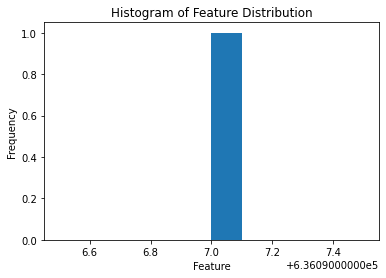

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data

# Plot a histogram
plt.hist(features.getnnz())
plt.xlabel('Feature')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Distribution')
plt.show()

# # Plot a box plot
# sns.boxplot(dense_features)
# plt.xlabel('Feature')
# plt.title('Box Plot of Feature Distribution')
# plt.show()

# # Plot a density plot
# sns.kdeplot(dense_features)
# plt.xlabel('Feature')
# plt.title('Density Plot of Feature Distribution')
# plt.show()

In [342]:
# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, df['mash'], test_size=0.4, random_state=777)

In [101]:
# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(best_features, df['mash'], test_size=0.4, random_state=777)

In [349]:
# Train the classifier
clf = MultinomialNB()
clf.fit(features_train, labels_train)

# Evaluate the classifier
accuracy = clf.score(features_test, labels_test)
print("Accuracy:", accuracy)

Accuracy: 0.9874503915048805


In [102]:
# Train the classifier
clf = RandomForestClassifier()
clf.fit(features_train, labels_train)

# Evaluate the classifier
accuracy = clf.score(features_test, labels_test)
print("Accuracy:", accuracy)

Accuracy: 0.9903464550037542


In [ ]:
ttr("batatetitotu")

In [103]:
palavras = ["world", "pizza", "arthur", "Douglas",
            "my", "as", "Incomprehensibilities", "aaaaaaaa", 
            "lllllllll", "bbbbbbbbb","actually","book", "think",
            "glass"]
for entrada in palavras:
    # Extract N-gram features for the new string
    input_ngram_features = vectorizer.transform([entrada])

    # Extract lexical features for the new string
    input_vowel_feature = csr_matrix(np.array(type_ratio(entrada, 'v')).reshape(-1,1))
    input_consonant_feature = csr_matrix(np.array(type_ratio(entrada, 'c')).reshape(-1,1))
    input_ttr_feature = csr_matrix(np.array(ttr(entrada)).reshape(-1,1))

    # Combine the N-gram and lexical features into a single feature matrix
    input_lexical_features = hstack((input_vowel_feature, input_consonant_feature, input_ttr_feature))
    best_input_ngram_features = selector.transform(input_ngram_features)
    input_features = hstack((input_lexical_features, best_input_ngram_features))
    # input_features = hstack((input_lexical_features, input_ngram_features))

    # Make the prediction using the trained model
    prediction = clf.predict(input_features)
    predprob = clf.predict_proba(input_features)
    # Print the prediction
    print(f"{prediction}:{entrada}:{predprob}")

[0]:world:[[1. 0.]]
[0]:pizza:[[0.67 0.33]]
[0]:arthur:[[0.99 0.01]]
[0]:Douglas:[[0.98 0.02]]
[0]:my:[[1. 0.]]
[0]:as:[[1. 0.]]
[0]:Incomprehensibilities:[[0.92 0.08]]
[1]:aaaaaaaa:[[0.21 0.79]]
[1]:lllllllll:[[0.44 0.56]]
[1]:bbbbbbbbb:[[0.26 0.74]]
[0]:actually:[[0.99 0.01]]
[0]:book:[[0.99 0.01]]
[0]:think:[[1. 0.]]
[0]:glass:[[0.99 0.01]]


In [87]:
entrada = input("")
# Extract N-gram features for the new string
input_ngram_features = vectorizer.transform([entrada])

# Extract lexical features for the new string
input_vowel_feature = csr_matrix(np.array(type_ratio(entrada, 'v')).reshape(-1,1))
input_consonant_feature = csr_matrix(np.array(type_ratio(entrada, 'c')).reshape(-1,1))
input_ttr_feature = csr_matrix(np.array(ttr(entrada)).reshape(-1,1))

# Combine the N-gram and lexical features into a single feature matrix
input_lexical_features = hstack((input_vowel_feature, input_consonant_feature, input_ttr_feature))
best_input_ngram_features = selector.transform(input_ngram_features)
input_features = hstack((input_lexical_features, best_input_ngram_features))
# input_features = hstack((input_lexical_features, input_ngram_features))

# Make the prediction using the trained model
prediction = clf.predict(input_features)
predprob = clf.predict_proba(input_features)
# Print the prediction
print(f"{prediction}:{entrada}:{predprob}")

[0]:gaussian:[[0.68 0.32]]


In [104]:
entradas = ["yhtecwtatnelurf ", "xzdagohdnioliou ", "cictutbuvjnartoltitf", "ptulldegnjkruormytrq",
         "lnaebzbanatidiviejiu", "yatiacodlwalthrpzaao", "pruteebci", "zaembaedzc", "ihnccitws",
         "rondlrpe", "loeniaerkhyh", "ipippipoiopiopiopiop", "ipoiopiopipoipoiopiopiopio", "poipoiopopipioppi",
         "opoiopipoiopipoiop", "iopoioiopipoipoipo", "iouiuioiuouiuiouoioiu", "iouiouiouiouoiuioui", "ouiouiouiouiuyiiu",
         "rtyytrrytrytytrytryt", "trtrtrtrterererererererer", "ewewewewewewrerer", "ererereretrtetrtrtrytyt", "tyuituyituyuitoippoipoi",
         "zqmapmplmlpmlpmplpmlpmlpmlpmlpmlpmllpmlpmlpmlpmlpmlmlpmlplmpl", "c7pprmeeduss", "weustt9nneas", "tbassuahpfep",
         "kiraezy", "itheair", "nepsawl", "hwrcosb", "finiefj", "nmimcom", "hriphao", "xourgec", "tacimu4", "ouiulct",
         "nuppuno", "a8nutss", "knfelnpesroopcc", "vpieaporitfuccy", "jiaxddeuhnturarefj", "eu1cvgirtronn"]
falso_negativo = 0
for entrada in entradas:
    # Extract N-gram features for the new string
    input_ngram_features = vectorizer.transform([entrada])

    # Extract lexical features for the new string
    input_len_feature = csr_matrix(np.array(len(entrada)).reshape(-1,1))
    input_vowel_feature = csr_matrix(np.array(type_ratio(entrada, 'v')).reshape(-1,1))
    input_consonant_feature = csr_matrix(np.array(type_ratio(entrada, 'c')).reshape(-1,1))
    input_ttr_feature = csr_matrix(np.array(ttr(entrada)).reshape(-1,1))

    # Combine the N-gram and lexical features into a single feature matrix
    input_lexical_features = hstack((input_vowel_feature, input_consonant_feature, input_ttr_feature))
    best_input_ngram_features = selector.transform(input_ngram_features)
    input_features = hstack((input_lexical_features, best_input_ngram_features))
    # input_features = hstack((input_lexical_features, input_ngram_features))

    # Make the prediction using the trained model
    prediction = clf.predict(input_features)
    if prediction[0] == 0:
        falso_negativo += 1
    # Print the prediction
    print(f"{prediction}:{entrada}")
print(f"{falso_negativo}")

[1]:yhtecwtatnelurf 
[1]:xzdagohdnioliou 
[1]:cictutbuvjnartoltitf
[1]:ptulldegnjkruormytrq
[1]:lnaebzbanatidiviejiu
[1]:yatiacodlwalthrpzaao
[1]:pruteebci
[1]:zaembaedzc
[1]:ihnccitws
[1]:rondlrpe
[1]:loeniaerkhyh
[1]:ipippipoiopiopiopiop
[1]:ipoiopiopipoipoiopiopiopio
[1]:poipoiopopipioppi
[1]:opoiopipoiopipoiop
[1]:iopoioiopipoipoipo
[1]:iouiuioiuouiuiouoioiu
[1]:iouiouiouiouoiuioui
[1]:ouiouiouiouiuyiiu
[1]:rtyytrrytrytytrytryt
[1]:trtrtrtrterererererererer
[1]:ewewewewewewrerer
[1]:ererereretrtetrtrtrytyt
[1]:tyuituyituyuitoippoipoi
[1]:zqmapmplmlpmlpmplpmlpmlpmlpmlpmlpmllpmlpmlpmlpmlpmlmlpmlplmpl
[0]:c7pprmeeduss
[1]:weustt9nneas
[1]:tbassuahpfep
[0]:kiraezy
[1]:itheair
[0]:nepsawl
[1]:hwrcosb
[0]:finiefj
[1]:nmimcom
[1]:hriphao
[1]:xourgec
[0]:tacimu4
[1]:ouiulct
[0]:nuppuno
[0]:a8nutss
[0]:knfelnpesroopcc
[1]:vpieaporitfuccy
[1]:jiaxddeuhnturarefj
[1]:eu1cvgirtronn
8


In [24]:
with open ("..\\data\\raw\\words.csv", "r", encoding="utf-8") as file1:
    words = pd.DataFrame(pd.read_csv(file1, keep_default_na=False))
strwords = words.words.to_list()

In [25]:
i = 0
for entrada in strwords:
    i += 1
    if (i % 100 != 0):
        continue
    # Extract N-gram features for the new string
    input_ngram_features = vectorizer.transform([entrada])

    # Extract lexical features for the new string
    input_vowel_feature = csr_matrix(np.array(type_ratio(entrada, 'v')).reshape(-1,1))
    input_consonant_feature = csr_matrix(np.array(type_ratio(entrada, 'c')).reshape(-1,1))
    input_ttr_feature = csr_matrix(np.array(ttr(entrada)).reshape(-1,1))

    # Combine the N-gram and lexical features into a single feature matrix
    input_lexical_features = hstack((input_vowel_feature, input_consonant_feature, input_ttr_feature))
    input_features = hstack((input_lexical_features, input_ngram_features))

    # Make the prediction using the trained model
    prediction = clf.predict(input_features)

    # Print the prediction
    if prediction:
        print(f"{entrada}")


calciobiotite


KeyboardInterrupt: 

In [ ]:
with open ("..\\data\\raw\\falsospositivos.txt", "r", encoding="utf-8") as file1:
    fpos = [line.rstrip('\n') for line in file1]
with open ("..\\data\\raw\\erros_ml_words.txt", "r", encoding="utf-8") as file2:
    erros = [line.rstrip('\n') for line in file2]


In [ ]:
i = 0
for word in erros:
    try:
        if fpos.index(word) != ValueError:
            print(f"{word}")
    except:
        continue;